In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import torch
import h5py
from load_data import voxelize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from io import BytesIO
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

def visualize_voxel(voxel_grid):
    """
    Visualizes a 3D binary voxel grid using matplotlib.

    Parameters:
    voxel_grid (numpy.ndarray): A 3D binary voxel grid where 1 indicates occupancy and 0 indicates empty.
    """

    # Get the coordinates of occupied voxels
    occupied_voxels = np.argwhere(voxel_grid == 1)

    # Create a 3D plot
    fig = plt.figure()
    plt.tight_layout()

    ax = fig.add_subplot(111, projection='3d')

    # Plot occupied voxels as scatter points
    ax.scatter(occupied_voxels[:, 0], occupied_voxels[:, 2], occupied_voxels[:, 1])

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set the aspect ratio to be equal
    ax.set_box_aspect([1, 1, 1])

    # ax = fig.add_subplot(111, projection='3d')
    # ax.voxels(voxel_grid, facecolors='cyan', edgecolor='k')

    # Set the limits for the axes
    ax.set_xlim([0, voxel_grid.shape[0]])
    ax.set_ylim([0, voxel_grid.shape[1]])
    ax.set_zlim([0, voxel_grid.shape[2]])
    plt.show()
    ax.axis("off")
    plt.show()
    # return None
    # buf = BytesIO()
    # plt.savefig(buf, format='png')
    # buf.seek(0)  # Move the buffer cursor to the beginning
    # plt.close()
    # # Convert the buffer into a Pillow Image
    # img = Image.open(buf)
    # return img

In [2]:
# load the preprocessed voxel data.
voxels = np.load("./data/hdf5_data/chair_voxels_val.npy")
print(voxels.shape)

(396, 128, 128, 128)


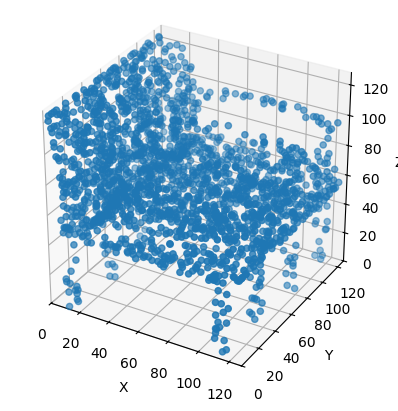

In [3]:
visualize_voxel(voxels[0])
# display(img)

In [4]:
from einops import rearrange
voxel2 = rearrange(voxels[0], '(H h) (W w) (D d) -> H W D (h w d)', h=4, w=4, d=4)
voxel2 = voxel2.sum(axis=3)
voxel2 = (voxel2 >= 1.0)*1.0

In [113]:
import torch.nn as nn
conv = nn.Conv3d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
# Initialize weight of conv to make it as a mean filter
conv.weight.data.fill_(1.0/27)

tensor([[[[[0.0370, 0.0370, 0.0370],
           [0.0370, 0.0370, 0.0370],
           [0.0370, 0.0370, 0.0370]],

          [[0.0370, 0.0370, 0.0370],
           [0.0370, 0.0370, 0.0370],
           [0.0370, 0.0370, 0.0370]],

          [[0.0370, 0.0370, 0.0370],
           [0.0370, 0.0370, 0.0370],
           [0.0370, 0.0370, 0.0370]]]]])

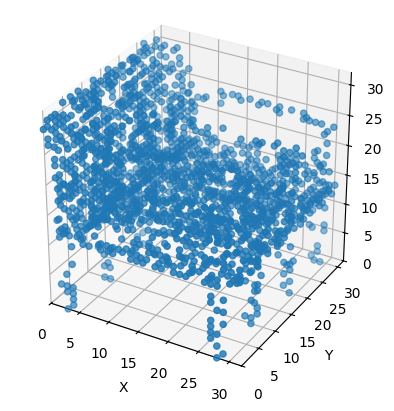

None

In [6]:
img = visualize_voxel(voxel2)
display(img)

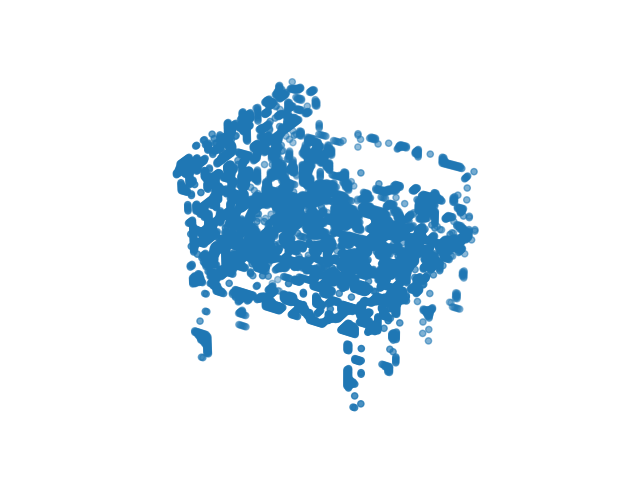

In [102]:
from scipy.ndimage import zoom
resize_voxel2 = zoom(voxel2, (4, 4, 4), order=1)
resize_voxel2 = (resize_voxel2 > 0.8) * 1.0
img = visualize_voxel(resize_voxel2)
display(img)

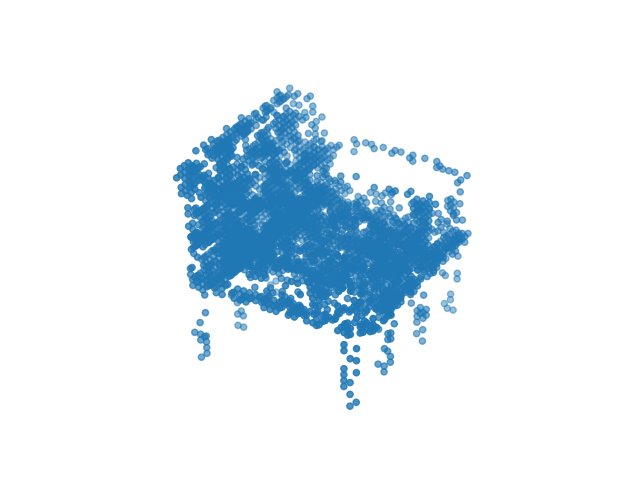

In [115]:
voxel3 = conv(torch.tensor(voxel2, dtype=torch.float).unsqueeze(0).unsqueeze(0)).squeeze().detach().numpy()
voxel3 = (voxel3 + voxel2 > 0.2) * 1.0
img = visualize_voxel(voxel3)
display(img)

Check sum before transformation:  2047.0
Check sum after transformation:  14606.0


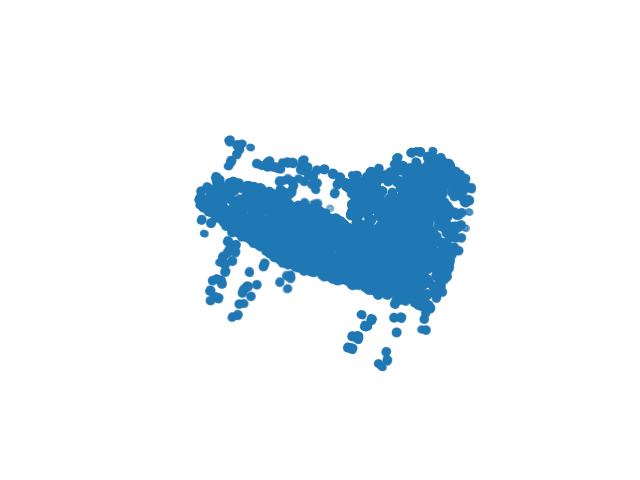

In [4]:
from volumentations import *

aug = Compose([
    Flip(0, p=0.5),
    Rotate((-45,45), (0, 0), (0,0), always_apply=True),
])

target = voxels[0]
augmented = aug(image=voxels[0])
transformed = augmented['image']
transformed[transformed > 0] = 1
transformed[transformed <= 0] = 0

print("Check sum before transformation: ", np.sum(target))
print("Check sum after transformation: ", np.sum(transformed))

img = visualize_voxel(transformed)
display(img)